In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from keras import models
from keras import layers
from keras import optimizers
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
from statistics import mean
from keras.utils import load_img, img_to_array

#import modules
import os
from keras.applications import VGG16

In [21]:
image_height = 200
image_weight = 150
sequence = 3

def arrange_data(df, map):
    image_data = []
    ids = df[df.columns[0]]
    map = f"{map}/raw_images/"
    
    df = df.drop(df.columns[0], axis=1)
    
    for i in ids:
        img = load_img(f"{map}{i}.jpg", target_size=(image_height, image_weight, sequence))
        img = img_to_array(img)
        image_data.append(img)
    
    X = np.array(image_data)
    Y = np.array(df)
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

In [22]:
# splitting data and 
current_folder = os.path.abspath('')
map = f"{current_folder}/data/"

# reads first row as header
print("Processing train..")
train_df = pd.read_csv(f"{map}train.csv", delimiter=',', header=None)
X_train, Y_train = arrange_data(train_df, current_folder)

# reads first row double
print("Processing valid..")
val_df = pd.read_csv(f"{map}valid.csv", delimiter=',', header=0)
X_val, Y_val = arrange_data(val_df, current_folder)

# scale data 
X_train = X_train / 255
X_val = X_val / 255


Processing train..
Shape of images: (612, 200, 150, 3)
Shape of labels: (612, 26)
Processing valid..
Shape of images: (236, 200, 150, 3)
Shape of labels: (236, 26)


In [23]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_weight, sequence))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

num_classes = 26

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(num_classes, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              12583936  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 26)                26650     
                                                                 
Total params: 27,325,274
Trainable params: 19,690,010
Non-trainable params: 7,635,264
_________________________________________________________________


In [24]:
version = 'v2'

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest")

# train the network
EPOCHS=50
BS = 64

history = model.fit(aug.flow(X_train, Y_train, batch_size=BS),validation_data=(X_val, Y_val), 
                    steps_per_epoch=len(X_train) // BS, epochs=EPOCHS)

model.save(f'{current_folder}/model/pretrained/{version}/Model_4c_{version}.h5')

c:\Users\cheeyau\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
9/9 [==============================] - 56s 6s/step - loss: 0.3741 - accuracy: 0.1493 - val_loss: 0.2388 - val_accuracy: 0.1907
Epoch 2/50
9/9 [==============================] - 55s 6s/step - loss: 0.2557 - accuracy: 0.2431 - val_loss: 0.2226 - val_accuracy: 0.3432
Epoch 3/50
9/9 [==============================] - 53s 6s/step - loss: 0.2508 - accuracy: 0.2847 - val_loss: 0.2245 - val_accuracy: 0.2754
Epoch 4/50
9/9 [==============================] - 53s 6s/step - loss: 0.2404 - accuracy: 0.3175 - val_loss: 0.2188 - val_accuracy: 0.2797
Epoch 5/50
9/9 [==============================] - 54s 6s/step - loss: 0.2285 - accuracy: 0.3066 - val_loss: 0.2290 - val_accuracy: 0.2754
Epoch 6/50
9/9 [==============================] - 53s 6s/step - loss: 0.2267 - accuracy: 0.3102 - val_loss: 0.2223 - val_accuracy: 0.3602
Epoch 7/50
9/9 [==============================] - 53s 6s/step - loss: 0.2190 - accuracy: 0.3248 - val_loss: 0.2159 - val_accuracy: 0.4364
Epoch 8/50
9/9 [==================

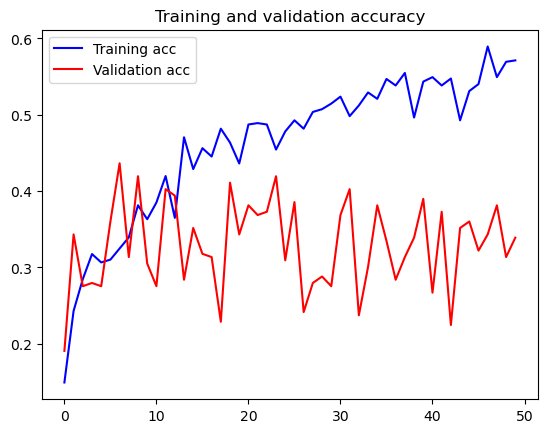

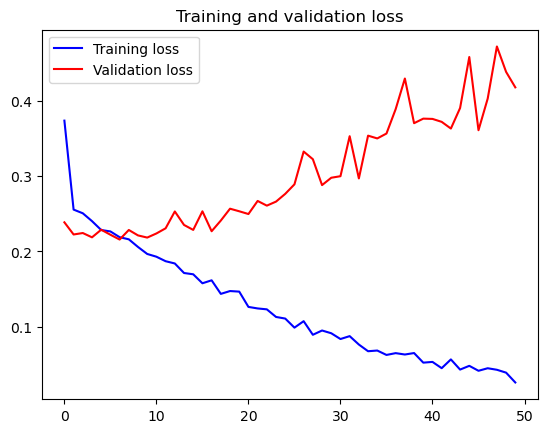

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()